In [ ]:
%pip install unsloth datasets dotenv huggingface_hub torch matplotlib

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import os
os.environ['HF_HOME'] = '/workspace/.cache/huggingface'

In [3]:
from unsloth import FastLanguageModel

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model_name = "unsloth/Meta-Llama-3.1-8B-Instruct"
# model_name = "NousResearch/Hermes-2-Pro-Llama-3-8B"
# model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"

model, tokenizer = FastLanguageModel.from_pretrained(   
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/workspace/fine-tunning-models/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.9: Fast Llama patching. Transformers: 4.55.3.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.422 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.8.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [5]:
# save a copy because apply_chat_template() has in-place modifications
import copy

tokenizer_orig = copy.deepcopy(tokenizer)

# Download Dataset And Formatting

In [6]:
from datasets import load_dataset

dataset_orig = load_dataset("jeanmcm/ed-risk", split="train")
dataset = dataset_orig

Generating train split: 100%|██████████| 39422/39422 [00:00<00:00, 146857.34 examples/s]


## Formatting (Optional or depents of dataset Type)

In [ ]:
def validate_messages_format(messages):
    """
    Validates the format of the messages list and counts interactions.

    Args:
        messages (list): A list of dictionaries representing messages.

    Returns:
        tuple: (bool, int) - True if the format is valid and the number of interactions (pairs of user/assistant messages), False and 0 otherwise.
    """
    if len(messages) % 2 != 0:
        return False, 0  # Length must be even

    user_count = 0
    assistant_count = 0
    for i, message in enumerate(messages):
        if i % 2 == 0:
            if message.get('role') != 'user':
                return False, 0  # Even indexed messages should have 'user' role
            user_count += 1
        else:
            if message.get('role') != 'assistant':
                return False, 0  # Odd indexed messages should have 'assistant' role
            assistant_count += 1

    if user_count == assistant_count:
        return True, user_count  # Return True and the number of interactions
    else:
        return False, 0

def clean_invalid_messages(messages):
    """
    Cleans invalid message sequences by keeping only the valid alternating pairs.

    Args:
        messages (list): A list of dictionaries representing messages.

    Returns:
        list: A list containing only the valid alternating user/assistant message pairs.
    """
    cleaned_messages = []
    for i in range(0, len(messages) - 1, 2):
        if messages[i].get('role') == 'user' and messages[i+1].get('role') == 'assistant':
            cleaned_messages.append(messages[i])
            cleaned_messages.append(messages[i+1])
        else:
            # Stop if the pattern is broken
            break
    return cleaned_messages


def validate_dataset(dataset):
    valid_dataset = []
    invalid_dataset = []

    # Iterate through the dataset and validate the messages
    for example in dataset:
        is_valid, _ = validate_messages_format(example['messages'])
        if is_valid:
            valid_dataset.append(example)
        else:
            invalid_dataset.append(example)

    print(f"Total number of valid examples: {len(valid_dataset)}")
    print(f"Total number of invalid examples: {len(invalid_dataset)}")

    cleaned_invalid_dataset = []
    # Clean the invalid messages and re-validate
    for example in invalid_dataset:
        cleaned_messages = clean_invalid_messages(example['messages'])
        is_valid, interactions = validate_messages_format(cleaned_messages)
        if is_valid:
            cleaned_invalid_dataset.append({'messages': cleaned_messages, 'topic': example['topic']})


    print(f"\nTotal number of cleaned invalid examples that are now valid: {len(cleaned_invalid_dataset)}")

    combined_dataset = valid_dataset + cleaned_invalid_dataset

    print(f"Total number of examples in the combined dataset: {len(combined_dataset)}")

    return combined_dataset        


In [ ]:
from datasets import Dataset

system_prompt = """
Eres un asistente con amplios conocimientos en el tema: {}. 
Responde de forma clara, precisa y útil, adaptando la complejidad según el nivel del usuario.
"""

def format_dataset(dataset,split_pairs=False, show_assistant_message=True):
    
    valid_dataset = validate_dataset(dataset)
    
    if not show_assistant_message and not split_pairs:
        return Dataset.from_list([{'messages': conversation} for conversation in valid_dataset])
    
    conversations = []

    for example in valid_dataset:
        messages = example['messages']
        topic = example['topic'] 
        system_message = {"role": "system", "content": system_prompt.format(topic)} 

        if split_pairs:
            for i in range(0, len(messages), 2):
                if i + 1 < len(messages): # Ensure there's a next message for a pair
                    # Prepend the system message to the interaction pair
                    retrievals = [system_message, messages[i], messages[i+1]]
                    if not show_assistant_message:
                        retrievals.pop(0)
                    conversations.append(retrievals)
        else:
            conversations.append([system_message,*messages])
    
     
    return Dataset.from_list([{'messages': conversation} for conversation in conversations])


In [ ]:
dataset = format_dataset(dataset_orig,
                         show_assistant_message=True,
                         split_pairs=True)

# Template

## Llama 3.1 Template

In [ ]:
# Optional
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

In [7]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer
)

Unsloth: Will map <|im_end|> to EOS = <|eot_id|>.


In [8]:
from unsloth import standardize_sharegpt

# Adjust the formatting function to handle the new structure
def formatting_prompts_func(examples):
    convos = examples["messages"]
    for convo in convos:
        user_conv = convo[0]
        if not str(user_conv["content"]).endswith("?"):
            user_conv["content"] = str(user_conv["content"]).replace("¿","")
        
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

# Apply the formatting function to the new dataset
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map: 100%|██████████| 39422/39422 [00:01<00:00, 23549.92 examples/s]


In [9]:
dataset[5]['messages']

[{'role': 'user',
  'content': 'En qué casos se debe utilizar el método basado en calificaciones internas (IRB) para la evaluación de posiciones de titulización según el texto, y cuál es su ámbito de aplicación'},
 {'role': 'assistant',
  'content': 'El método basado en calificaciones internas (IRB) para la evaluación de posiciones de titulización debe utilizarse en aquellas posiciones que sean parte de una titulización y que tengan un riesgo significativo que permita aplicar modelos internos de calificación para estimar la probabilidad de incumplimiento y la pérdida dada incumplimiento. Su ámbito de aplicación incluye las posiciones de titulización que cumplen con los requisitos establecidos para la utilización de modelos IRB, específicamente en aquellos casos en los que la institución financiera ha desarrollado y validado internamente estos modelos para evaluar el riesgo de las posiciones titulizadas. Este método se aplica en contextos donde la evaluación del riesgo requiere un análi

In [10]:
dataset[3]['text']

'<|im_start|>user\nQué porcentaje de CCF se aplica a las posiciones de los inversionistas en mecanismos controlados según las instrucciones para operaciones titulizadas con cláusulas de amortización anticipada controlada<|im_end|>\n<|im_start|>assistant\nSe aplica un porcentaje de CCF del 90% a las posiciones de los inversionistas en mecanismos controlados en operaciones titulizadas con cláusulas de amortización anticipada controlada.<|im_end|>\n'

## Alpaca Format

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

In [ ]:
from unsloth import standardize_sharegpt



def formatting_prompts_func(examples):
    convos = examples["messages"]
    #texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    texts = [alpaca_prompt.format(convo[0]["content"], convo[1]["content"], convo[2]['content']) + EOS_TOKEN for convo in convos]
    return { "text" : texts, }

# Convert the list of interaction sets back to a Dataset
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

## Custom Chat Template

In [ ]:
def custom_conversations(example):
  messages = example["messages"]
  messages_without_system = messages[1:]
  example["conversations"] = messages_without_system
  return example

dataset = dataset.map(custom_conversations)

dataset

In [ ]:
chat_template = """Below are some instructions that describe some tasks. Write responses that appropriately complete each request.

### Instruction:
{INPUT}

### Response:
{OUTPUT}"""

from unsloth import apply_chat_template


dataset = apply_chat_template(
    dataset,
    tokenizer=tokenizer,
    chat_template=chat_template,
    default_system_message = "You are a helpful assistant",
)

In [ ]:
dataset["conversations"][0]

In [ ]:
dataset[0]['text'].split('\n')

In [ ]:
dataset

# Tool Calling

In [ ]:
def get_vector_sum(a: list[float], b: list[float]) -> list[float]:
    """
    Performs element-wise addition of two numerical vectors.

    Both vectors must be of the same length and contain numerical values.

    Args:
        a: First vector containing numerical values
        b: Second vector containing numerical values

    Returns:
        Resulting vector where each element is the sum of corresponding elements in a and b

    Raises:
        ValueError: If vectors have different lengths

    Example:
        >>> get_vector_sum([1, 2], [3, 4])
        [4, 6]
    """
    if len(a) != len(b):
        raise ValueError("Vectors must be of the same length")

    return [x + y for x, y in zip(a, b)]

In [ ]:
user_query = {
    "role": "user",
    "content": "Find the sum of a = [1, -1, 2] and b = [3, 0, -4]."
}

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1", # change this to the right chat_template name
)

In [ ]:
messages = []

messages.append(user_query)

input_ids = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    add_special_tokens=False,
    padding=True,
    tools=[get_vector_sum],
    return_tensors="pt",
).to("cuda")

print(tokenizer.decode(input_ids[0]))

In [ ]:
%pip install transformers_cfg

In [ ]:
from functools import partial
from transformers_cfg.grammar_utils import IncrementalGrammarConstraint
from transformers_cfg.generation.logits_process import GrammarConstrainedLogitsProcessor
# from transformers import  AutoTokenizer


JSON_ARR_GBNF = r"""
# This is the same as json.gbnf but we restrict whitespaces at the end of the root array
# Useful for generating JSON arrays
root   ::= arr
value  ::= object | array | string | number | ("true" | "false" | "null") ws
arr  ::=
  "[\n" ws (
            value
    (",\n" ws value)*
  )? "]"
object ::=
  "{" ws (
            string ":" ws value
    ("," ws string ":" ws value)*
  )? "}" ws
array  ::=
  "[" ws (
            value
    ("," ws value)*
  )? "]" ws
string ::=
  "\"" (
    [^"\\\x7F\x00-\x1F] |
    "\\" (["\\/bfnrt] | "u" [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F]) # escapes
  )* "\"" ws
number ::= ("-"? ([0-9] | [1-9] [0-9]*)) ("." [0-9]+)? ([eE] [-+]? [0-9]+)? ws
# Optional space: by convention, applied in this grammar after literal chars when allowed
ws ::= ([ \t\n] ws)?
"""

def generate_with_grammar(model, input_ids, **kwargs):
    # tokenizer = FastLanguageModel.from_pretrained(model.config.name_or_path)
    grammar = IncrementalGrammarConstraint(JSON_ARR_GBNF, start_rule_name="root", tokenizer=tokenizer)
    grammar_processor = GrammarConstrainedLogitsProcessor(grammar)

    partial_generate = partial(
        model.generate,
        do_sample=False,
        repetition_penalty=1.1,
        num_return_sequences=1,
        logits_processor=[grammar_processor],  # Ensure grammar_processor is accessible
        temperature=None,
        top_p=None,
        top_k=None,
        sliding_window=None,
    )

    # Execute generation with merged parameters
    return partial_generate(
        input_ids=input_ids,
        **kwargs
    )

In [ ]:
output = generate_with_grammar(
    model=model,
    input_ids=input_ids
)

generated_tokens = output[:, input_ids.shape[1]:]

decoded_output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

for i, message in enumerate(decoded_output):
    print(f"{message}")

# Training

In [22]:
from trl import SFTConfig, SFTTrainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    packing = False, # Can make training 5x faster for short sequences.
    dataset_num_proc = 2,
    args = SFTConfig(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 3, # Set this for 1 full training run.
        max_steps = 500,
        learning_rate = 2e-4,
        logging_steps = 1,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

In [23]:
trainer.train_dataset

Dataset({
    features: ['messages', 'text', 'input_ids', 'attention_mask'],
    num_rows: 39422
})

In [24]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|im_start|>user\nEn qué casos se debe utilizar el método basado en calificaciones internas (IRB) para la evaluación de posiciones de titulización según el texto, y cuál es su ámbito de aplicación<|im_end|>\n<|im_start|>assistant\nEl método basado en calificaciones internas (IRB) para la evaluación de posiciones de titulización debe utilizarse en aquellas posiciones que sean parte de una titulización y que tengan un riesgo significativo que permita aplicar modelos internos de calificación para estimar la probabilidad de incumplimiento y la pérdida dada incumplimiento. Su ámbito de aplicación incluye las posiciones de titulización que cumplen con los requisitos establecidos para la utilización de modelos IRB, específicamente en aquellos casos en los que la institución financiera ha desarrollado y validado internamente estos modelos para evaluar el riesgo de las posiciones titulizadas. Este método se aplica en contextos donde la evaluación del riesgo requiere un análisi

In [25]:
import torch
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A40. Max memory = 44.422 GB.
7.135 GB of memory reserved.


In [26]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 39,422 | Num Epochs = 1 | Total steps = 500
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Step,Training Loss
1,1.084600
2,1.088300
3,1.076500
4,1.156700
5,1.108700
6,1.165200
7,1.106300
8,1.039500
9,1.078600
10,1.031500


In [27]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1741.2631 seconds used for training.
29.02 minutes used for training.
Peak reserved memory = 8.281 GB.
Peak reserved memory for training = 1.146 GB.
Peak reserved memory % of max memory = 18.642 %.
Peak reserved memory for training % of max memory = 2.58 %.


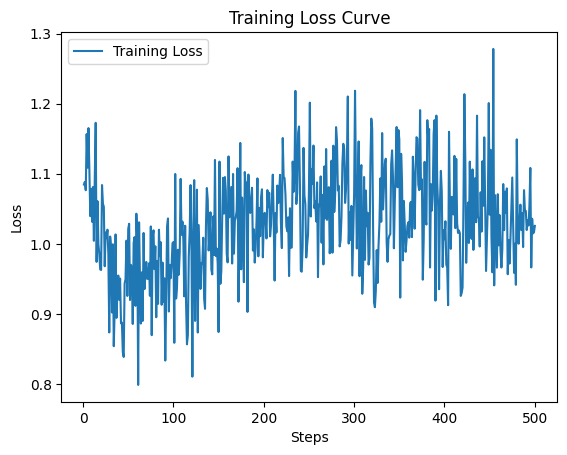

In [28]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
steps = [entry['step'] for entry in log_history if 'loss' in entry]
losses = [entry['loss'] for entry in log_history if 'loss' in entry]

# Crea la gráfica
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Inference

In [29]:
from transformers import TextStreamer

# Assuming model and tokenizer are already defined
FastLanguageModel.for_inference(model)



def generate_response(messages, tokenizer):
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")
    
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    _ = model.generate(
        input_ids,
        streamer=text_streamer,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id
    )

In [30]:
# Bulk messages for testing
bulk_messages = [
     [
        {"role": "user", "content": "Hola"}
    ],
    [
        {"role": "user", "content": "Hola Como estas"}
    ],
     [
        {"role": "user", "content": "Saludos"}
    ],
      [
        {"role": "user", "content": "Bom dia"}
    ],
       [
        {"role": "user", "content": "Hello!!"}
    ],
    [
        {"role":"user", "content":"2+2"},
        {"role":"assistant","content":"el resultado de 2+2 es *4*"},
        {"role": "user", "content": "Gracias por Ayudarme"}
    ],
    [
        {"role": "user", "content": "Me gustaría aprender sobre inteligencia artificial."}
    ],
    [
        {"role": "user", "content": "Explícame qué es el cambio climático."}
    ],
    [
        {"role": "user", "content": "Dime un chiste."}
    ],
    [
        {
        "role": "user",
        "content": "¿Qué ocurre con un estafador que paga por dos vehículos mediante transferencias bancarias y luego solicita un crédito de seis meses para la compra de otros dos vehículos?",
        }
    ],
    [
        {
            "role":"user",
            "content":"Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8"
        }
    ]
]

In [31]:
for messages in bulk_messages:
  print(f"QUERY: {messages[-1]['content']}\n")
  generate_response(messages,tokenizer)
  print("-"*100)
  print(f"\n")

QUERY: Hola



¡Hola!<|im_end|>
----------------------------------------------------------------------------------------------------


QUERY: Hola Como estas

Estoy bien, gracias. ¿Qué puedo ayudarte con la información proporcionada?<|im_end|>
----------------------------------------------------------------------------------------------------


QUERY: Saludos

Claro, saludos.<|im_end|>
----------------------------------------------------------------------------------------------------


QUERY: Bom dia

Bom dia!<|im_end|>
----------------------------------------------------------------------------------------------------


QUERY: Hello!!

¡Hola!<|im_end|>
----------------------------------------------------------------------------------------------------


QUERY: Gracias por Ayudarme

De nada, es un placer ayudarte.<|im_end|>
----------------------------------------------------------------------------------------------------


QUERY: Me gustaría aprender sobre inteligencia artificial.

¡Claro! La inte

## Lora

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
#model.push_to_hub(model_name, token = hf_token) # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

In [ ]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference



In [ ]:
from transformers import TextStreamer

# Assuming model and tokenizer are already defined
FastLanguageModel.for_inference(model)



def generate_response(messages, tokenizer):
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")
    
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    _ = model.generate(
        input_ids,
        streamer=text_streamer,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id
    )

In [ ]:
for messages in bulk_messages:
  print(f"QUERY: {messages[-1]['content']}\n")
  generate_response(messages,tokenizer)
  print("-"*100)
  print(f"\n")

# Save to GGUF

In [32]:
tokenizer._ollama_modelfile.split('\n')

['',
 'FROM {__FILE_LOCATION__}',
 'TEMPLATE """{{ if .System }}<|im_start|>system',
 '{{ .System }}<|im_end|>',
 '{{ end }}{{ if .Prompt }}<|im_start|>user',
 '{{ .Prompt }}<|im_end|>',
 '{{ end }}<|im_start|>assistant',
 '{{ .Response }}<|im_end|>',
 '"""',
 'PARAMETER stop "<|im_start|>"',
 'PARAMETER stop "<|im_end|>"',
 'PARAMETER temperature 1.5',
 'PARAMETER min_p 0.1',
 '']

In [33]:
from dotenv import load_dotenv
load_dotenv()

True

In [38]:
import os

hf_token = os.environ.get("HUGGING_FACE_KEY")
model_name ="jeanmcm/llama3.1-ed-risk"

In [39]:
# Save to 8bit Q8_0
# if False: model.save_pretrained_gguf(model_name, tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
# if False: model.push_to_hub_gguf(model_name, tokenizer, token = hf_token)

# Save to 16bit GGUF
# if False: model.save_pretrained_gguf(model_name, tokenizer, quantization_method = "f16")
# if False: model.push_to_hub_gguf(model_name, tokenizer, quantization_method = "f16", )

# Save to q4_k_m GGUF
model.save_pretrained_gguf(model_name, tokenizer, quantization_method = "q4_k_m")


make: Entering directory '/workspace/fine-tunning-models/llama.cpp'
make: Leaving directory '/workspace/fine-tunning-models/llama.cpp'


Makefile:6: *** Build system changed:
 The Makefile build has been replaced by CMake.

 For build instructions see:
 https://github.com/ggml-org/llama.cpp/blob/master/docs/build.md

.  Stop.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Git: /usr/bin/git (found version "2.34.1") 


CMAKE_BUILD_TYPE=Release


-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- ccache found, compilation results will be cached. Disable with GGML_CCACHE=OFF.
-- CMAKE_SYSTEM_PROCESSOR: x86_64
-- GGML_SYSTEM_ARCH: x86
-- Including CPU backend
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- x86 detected
-- Adding CPU backend variant ggml-cpu: -march=native 
-- ggml version: 0.0.6240
-- ggml commit:  54a241f5
-- Found CURL: /usr/lib/x86_64-linux-gnu/libcurl.so (found version "7.81.0")  
-- Configuring done
-- Generating done
-- Build files have been written to: /workspace/fine-tunning-models/llama.cpp/build
Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 392.77 out of 503.51 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [00:00<00:00, 36.43it/s]


Unsloth: Saving tokenizer... Done.
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at jeanmcm/llama3.1-ed-risk into bf16 GGUF format.
The output location will be /workspace/fine-tunning-models/jeanmcm/llama3.1-ed-risk/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: llama3.1-ed-risk
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, sha

Save to hugging Face Hub

In [ ]:
model.push_to_hub_gguf(model_name, tokenizer, quantization_method = "q4_k_m", token = hf_token)

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 390.73 out of 503.51 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [00:00<00:00, 39.18it/s]


Unsloth: Saving tokenizer... Done.
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at jeanmcm/llama3.1-ed-risk into bf16 GGUF format.
The output location will be /workspace/fine-tunning-models/jeanmcm/llama3.1-ed-risk/unsloth.BF16.gguf
This might take 3 minutes...
  File "/workspace/fine-tunning-models/llama.cpp/convert_hf_to_gguf.py", line 34
    try:
    ^
IndentationError: expected an indented block after 'try' statement on line 33
Unsloth: Conversion completed! Output location: /workspace/fine-tunning-models/jeanmcm/llama3.1-ed-risk/unsloth.BF16.gguf
Unsloth: [2] Converting GGUF 16bit into q4_k_